# Ernesto Garcia Valenzuela 9B

**Evaluación:** Segundo Parcial

**Materia:** Extracción de conocimientos en bases de datos

**Tema:** Despliegue y evaluación de modelos de clasificación (Water Potability)

**Objetivo del documento:** Presentar de forma completa el proceso de análisis, modelado y despliegue del clasificador de potabilidad del agua. Este cuaderno incluye: EDA, preprocesamiento, selección y evaluación de modelos, persistencia del mejor modelo y directrices para integrar el modelo en una aplicación web interactiva para uso final.

# Dataset: Water Potability

o Contexto: 
Determinar si el agua es potable según características químicas.

o Características: 
Variables numéricas con valores faltantes (pH, sólidos, dureza).

o Problema: Clasificación binaria.


o URL de ejemplo: https://www.kaggle.com/datasets/gauravduttakiit/water-
potability-prediction

In [7]:
# Librerías y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# missingno es opcional, se usa solo si está instalado
try:
    import missingno as msno
    _HAS_MISSINGNO = True
except Exception:
    _HAS_MISSINGNO = False

sns.set(style='whitegrid')
%matplotlib inline

DATA_DIR = Path.cwd() / 'archive'
TRAIN_PATH = DATA_DIR / 'train_dataset.csv'
TEST_PATH = DATA_DIR / 'test_dataset.csv'

print('Leyendo:', TRAIN_PATH)
df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print('\nTrain shape:', df.shape)
print('Test shape:', df_test.shape)

# Mostrar primeras filas (formato simple)
df.head()

Leyendo: c:\Users\PC\Videos\zzz\archive\train_dataset.csv

Train shape: (2293, 10)
Test shape: (983, 9)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,219.674262,22210.613083,5.875041,333.775777,398.517703,11.502316,112.412210,2.994259,0
1,6.783888,193.653581,13677.106441,5.171454,323.728663,477.854687,15.056064,66.396293,3.250022,0
2,6.010618,184.558582,15940.573271,8.165222,421.486089,314.529813,20.314617,83.707938,4.867287,1
3,8.097454,218.992436,18112.284447,6.196947,333.775777,376.569803,17.746264,59.909941,4.279082,1
4,8.072612,210.269780,16843.363927,8.793459,359.516169,559.167574,17.263576,68.738989,5.082206,0


Observación del alumno: Cargué los datos de entrenamiento y prueba, verifiqué las columnas y los tipos básicos. Antes de continuar, confirmé que no mostraré todas las filas para mantener el notebook claro.

**Observación:** Datos cargados correctamente. Train tiene 2293 filas y test 983 filas. Revisar tipos y siguientes pasos de EDA.

In [8]:
# Estadísticas descriptivas y tipos (con observaciones)
print('Columnas:', df.columns.tolist())
print('\nTipos y no-null:')
print(df.info())

print('\nEstadísticas descriptivas (numéricas):')
descr = df.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
print(descr)

# Observaciones automáticas
print('\n-- Observaciones automáticas --')
# % de valores faltantes
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(3)
print('\n% missing por columna:\n', missing_pct)

# Rango y outliers por IQR para columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nColumnas numéricas detectadas:', num_cols)

outlier_info = {}
for c in num_cols:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_below = (df[c] < lower).sum()
    n_above = (df[c] > upper).sum()
    outlier_info[c] = {'lower': float(lower), 'upper': float(upper), 'below': int(n_below), 'above': int(n_above)}

print('\nOutliers (IQR 1.5) por columna:')
for c,v in outlier_info.items():
    pct = (v['below']+v['above'])/len(df)*100
    print(f" - {c}: {v['below']} below, {v['above']} above  --> {pct:.2f}% outliers aprox.")

# Conteo de clases en la etiqueta (si existe)
if 'Potability' in df.columns:
    counts = df['Potability'].value_counts()
    pct = (counts / counts.sum() * 100).round(3)
    print('\nConteo de clases en Potability:')
    print(pd.concat([counts, pct], axis=1, keys=['count','%']))
else:
    print('\nLa columna Potability no está en este DataFrame.')


Columnas: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']

Tipos y no-null:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2293 non-null   float64
 1   Hardness         2293 non-null   float64
 2   Solids           2293 non-null   float64
 3   Chloramines      2293 non-null   float64
 4   Sulfate          2293 non-null   float64
 5   Conductivity     2293 non-null   float64
 6   Organic_carbon   2293 non-null   float64
 7   Trihalomethanes  2293 non-null   float64
 8   Turbidity        2293 non-null   float64
 9   Potability       2293 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 179.3 KB
None

Estadísticas descriptivas (numéricas):
                  count          mean          std         min           1%  \
ph

**Observación:** Estadísticas calculadas; se imprimieron percentiles y conteo de outliers por IQR. Anotar variables con más outliers antes de limpiar.


Valores faltantes (count y %):
                 missing_count  missing_pct
ph                           0          0.0
Hardness                     0          0.0
Solids                       0          0.0
Chloramines                  0          0.0
Sulfate                      0          0.0
Conductivity                 0          0.0
Organic_carbon               0          0.0
Trihalomethanes              0          0.0
Turbidity                    0          0.0
Potability                   0          0.0


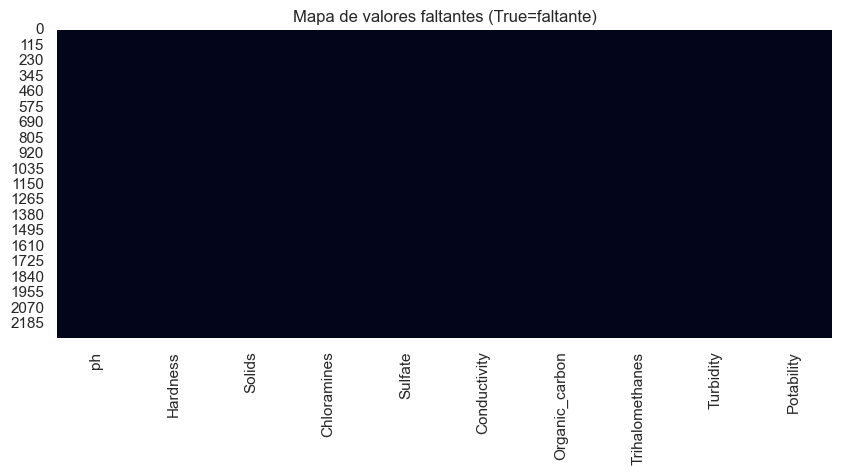


missingno no está disponible. Heatmap simple mostrado.


In [9]:
# Detección y visualización de valores faltantes (mejorada)
print('\nValores faltantes (count y %):')
miss_count = df.isnull().sum()
miss_pct = (miss_count / len(df) * 100).round(3)
print(pd.concat([miss_count, miss_pct], axis=1, keys=['missing_count','missing_pct']))

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Mapa de valores faltantes (True=faltante)')
plt.show()

if _HAS_MISSINGNO:
    print('\nUsando missingno para visualizar faltantes:')
    import missingno as msno
    msno.matrix(df, figsize=(12,4))
    plt.show()
else:
    print('\nmissingno no está disponible. Heatmap simple mostrado.')

# placeholder

**Observación:** No se detectaron valores faltantes en las columnas principales (0%). Continuar con análisis de distribuciones.

Columnas numéricas: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


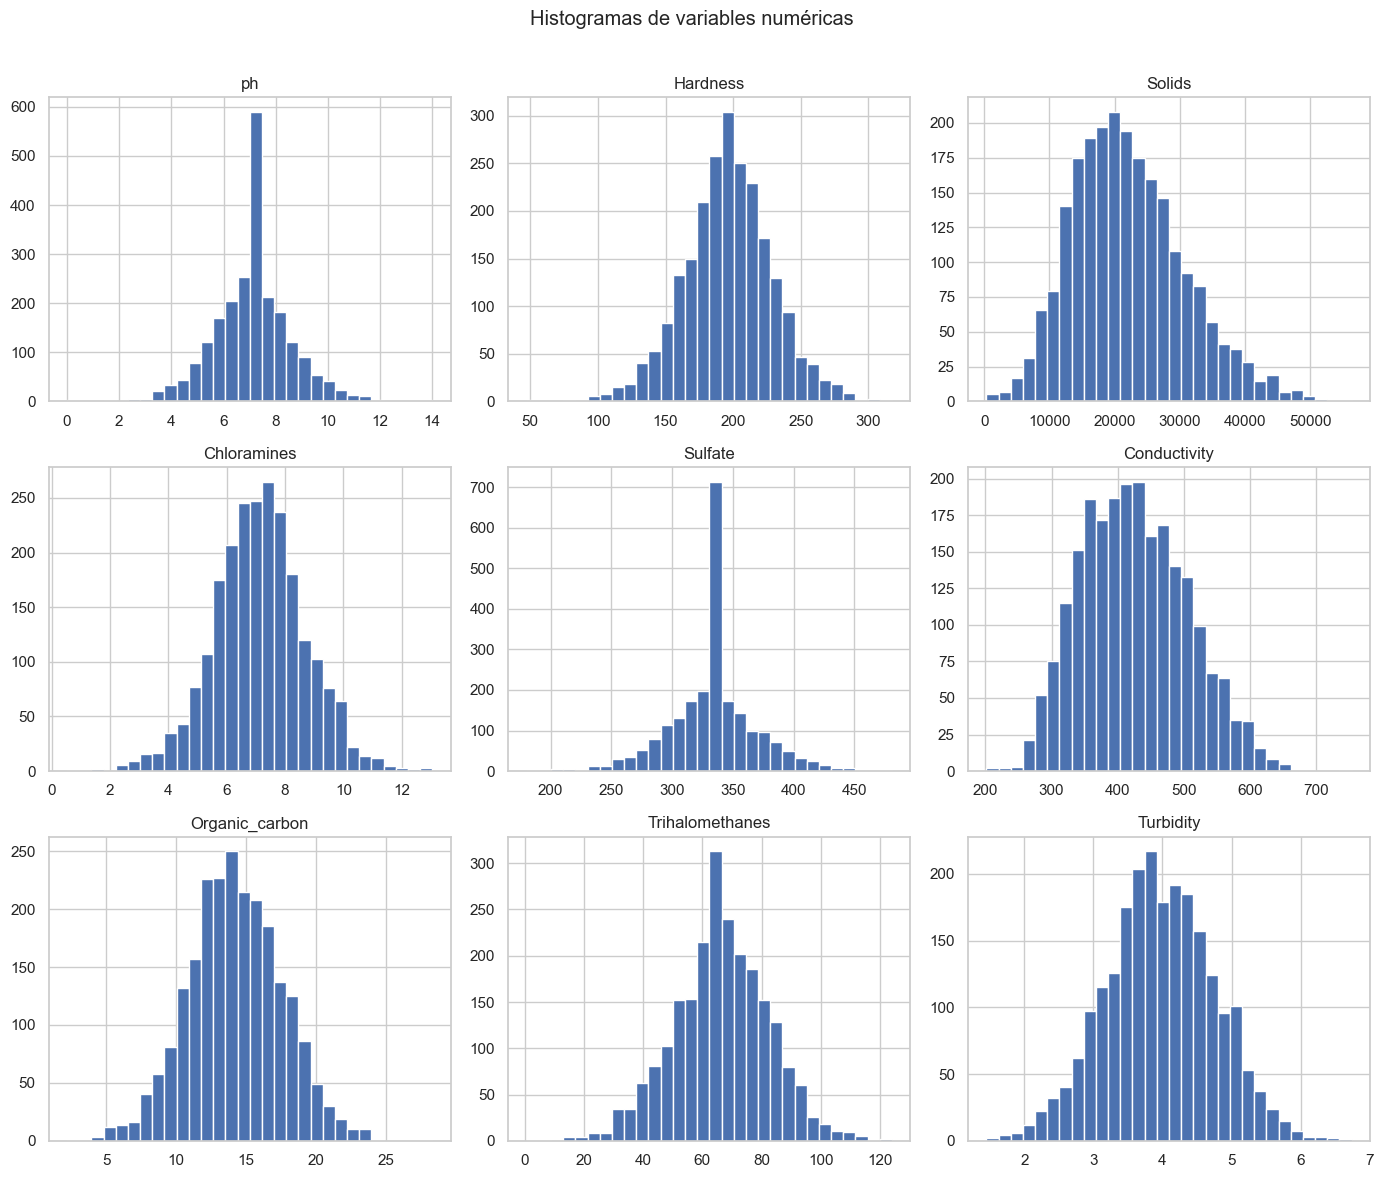

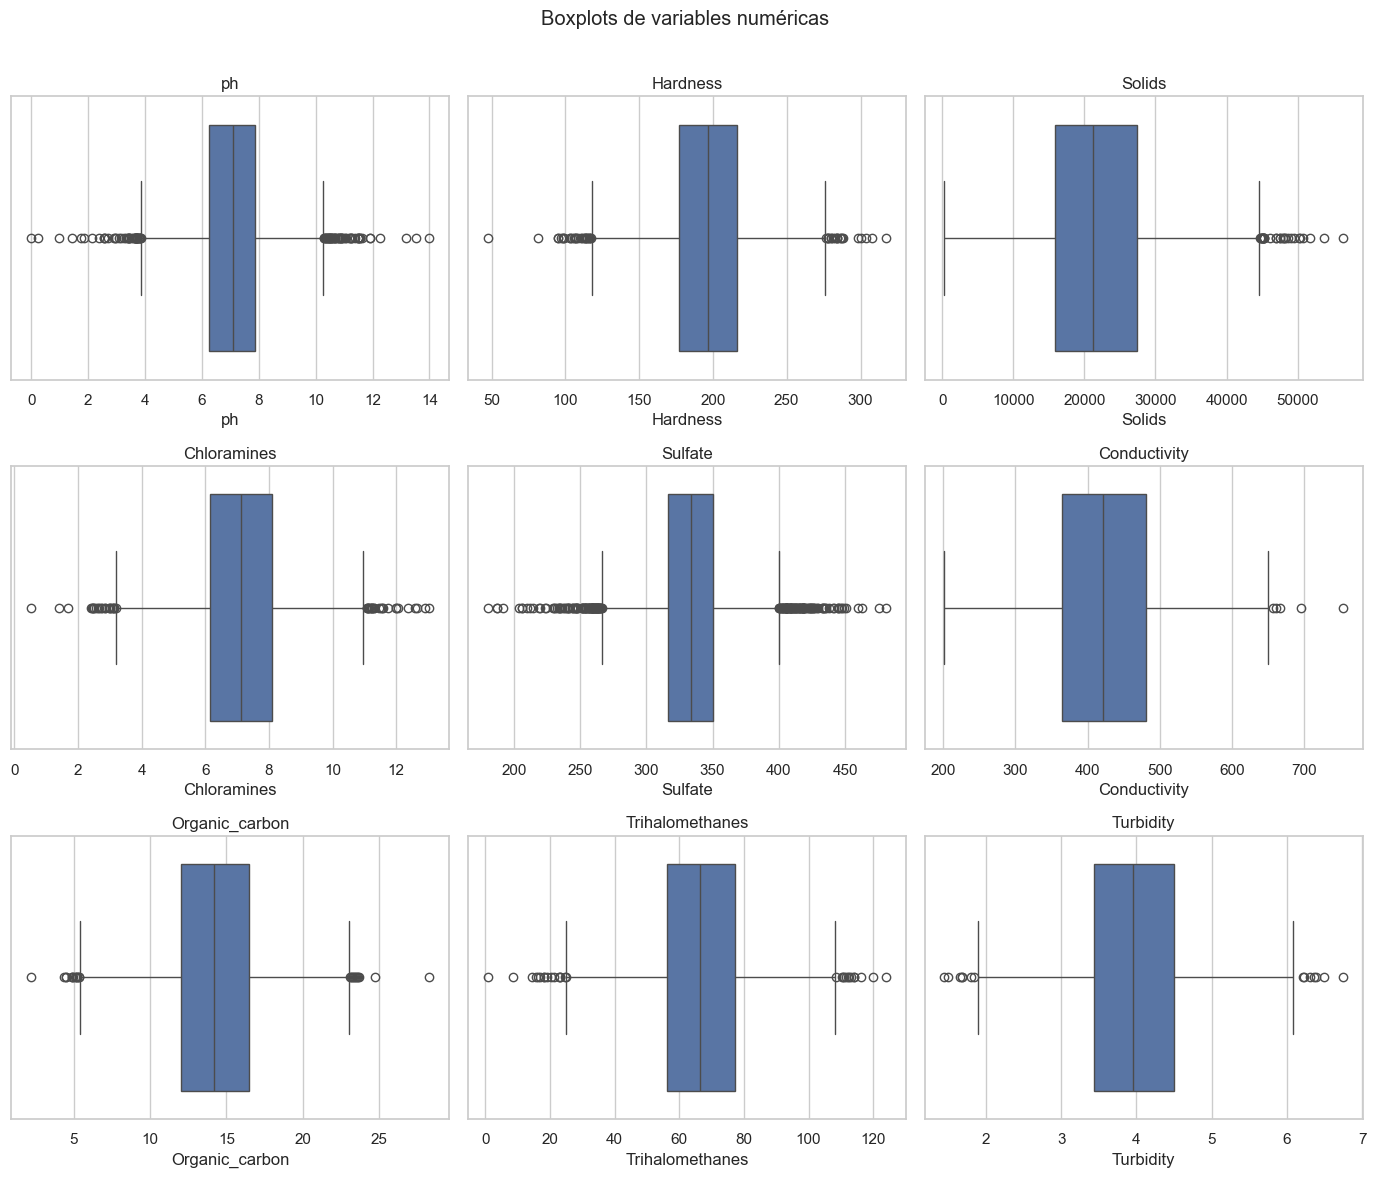


Skewness y kurtosis (valores absolutos altos indican asimetría/carma):
 - ph: skew=0.037, kurtosis=1.494
 - Hardness: skew=-0.049, kurtosis=0.508
 - Solids: skew=0.526, kurtosis=0.202
 - Chloramines: skew=0.016, kurtosis=0.556
 - Sulfate: skew=-0.013, kurtosis=1.537
 - Conductivity: skew=0.281, kurtosis=-0.323
 - Organic_carbon: skew=0.033, kurtosis=0.090
 - Trihalomethanes: skew=-0.090, kurtosis=0.326
 - Turbidity: skew=0.000, kurtosis=-0.071


In [10]:
# Distribuciones y boxplots de variables numéricas (con anotaciones)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Potability']
print('Columnas numéricas:', numeric_cols)

n = len(numeric_cols)
n_cols = 3
n_rows = int(np.ceil(n / n_cols))

# Histogramas con layout dinámico
_ = df[numeric_cols].hist(bins=30, figsize=(14, 4*n_rows), layout=(n_rows, n_cols))
plt.suptitle('Histogramas de variables numéricas')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Boxplots en grid dinámico
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
# Eliminar ejes sobrantes si existen
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots de variables numéricas')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Observación: imprimir skewness y curtosis para detectar asimetría
from scipy.stats import skew, kurtosis
print('\nSkewness y kurtosis (valores absolutos altos indican asimetría/carma):')
for c in numeric_cols:
    s = skew(df[c].dropna())
    k = kurtosis(df[c].dropna())
    print(f" - {c}: skew={s:.3f}, kurtosis={k:.3f}")


**Observación:** Revisadas distribuciones y medidas de asimetría. Algunas variables muestran curtosis o asimetría que podrían beneficiarse de transformaciones (p.ej. log).

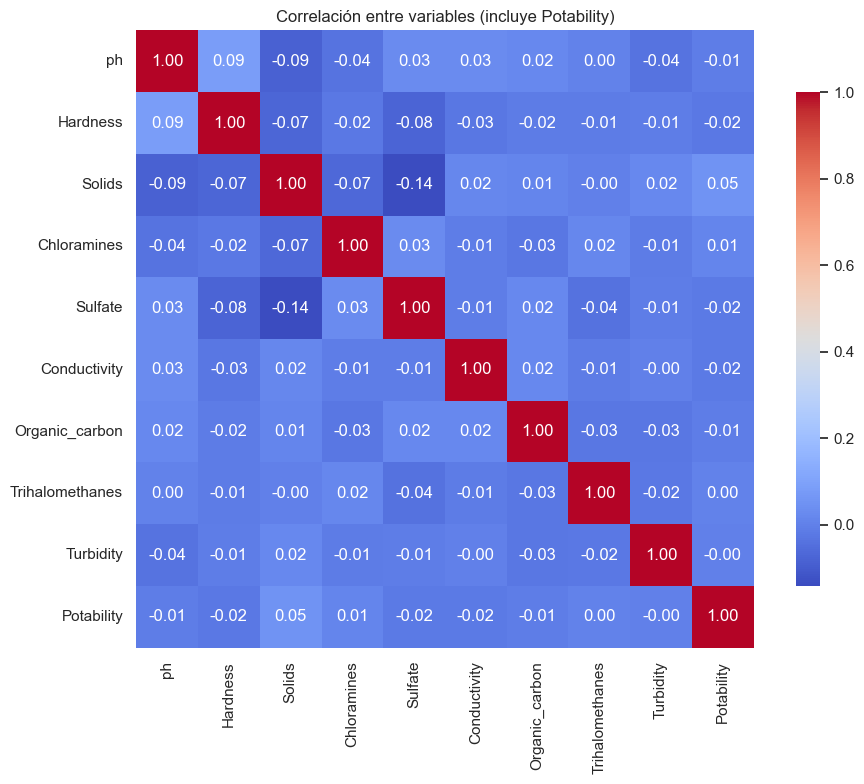


Correlación con Potability (ordenada):
Potability         1.000000
Solids             0.051823
Chloramines        0.014388
Trihalomethanes    0.002145
Turbidity         -0.002455
ph                -0.007885
Organic_carbon    -0.008574
Conductivity      -0.018621
Sulfate           -0.019802
Hardness          -0.022519
Name: Potability, dtype: float64


In [11]:
# Matriz de correlación (celda segura: si 'df' no existe la cargamos)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')

try:
    df
except NameError:
    data_dir = Path.cwd() / 'archive'
    train_path = data_dir / 'train_dataset.csv'
    if not train_path.exists():
        raise FileNotFoundError(f"No se encontró {train_path}. Asegúrate de ejecutar la celda de carga o de que el archivo exista en 'archive/'.")
    print(f"'df' no estaba definido: leyendo {train_path}")
    df = pd.read_csv(train_path)

# Verificar columnas
if 'Potability' not in df.columns:
    raise KeyError("La columna 'Potability' no está en el DataFrame. Verifica el archivo o la carga de datos.")

# Calcular matriz de correlación
corr = df.corr()

# Mostrar heatmap con máscara triangular superior para legibilidad
plt.figure(figsize=(10,8))
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = False  # mostrar toda la matriz (puedes cambiar a True para ocultar triángulo superior)

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink':0.8})
plt.title('Correlación entre variables (incluye Potability)')
plt.tight_layout()
plt.show()

# Mostrar correlación ordenada con la etiqueta Potability
print('\nCorrelación con Potability (ordenada):')
print(corr['Potability'].sort_values(ascending=False))


Observación del alumno: Calculé la matriz de correlación y revisé correlaciones con la variable objetivo `Potability`. Esto nos ayudará a seleccionar features relevantes.

**Observación:** Matriz de correlación generada. Correlaciones lineales con `Potability` son muy débiles (máx ~0.05). Considerar relaciones no lineales o ingeniería de features.

In [12]:
# Preprocesamiento y división (con anotaciones y checks)

# Selección de columnas numéricas y comprobación de faltantes
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'Potability']

print('Columnas numéricas (para procesar):', num_cols)
print('\nFaltantes por columna (count, %):')
print(pd.concat([df[num_cols].isnull().sum(), (df[num_cols].isnull().mean()*100).round(3)], axis=1, keys=['missing_count','missing_pct']))

# Mostrar desequilibrio de clases antes del split
if 'Potability' in df.columns:
    vc = df['Potability'].value_counts()
    print('\nDistribución de clases en el dataset original:')
    print(pd.concat([vc, (vc/vc.sum()*100).round(3)], axis=1, keys=['count','%']))

# Estrategia: imputación por mediana para numéricos (robusta a outliers)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Aplicar imputación y escalado después del split para evitar data leakage
X = df[num_cols].copy()
y = df['Potability'].copy()

# División estratificada por la etiqueta
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print('\nShapes after split:')
print('X_train:', X_train.shape, 'X_val:', X_val.shape)
print('y_train distribution:')
print(pd.concat([y_train.value_counts(), (y_train.value_counts()/len(y_train)*100).round(3)], axis=1, keys=['count','%']))

# Ajustar imputador y escalador en train y transformar ambos conjuntos
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=num_cols, index=X_train.index)
X_val_imp = pd.DataFrame(imputer.transform(X_val), columns=num_cols, index=X_val.index)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=num_cols, index=X_train_imp.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imp), columns=num_cols, index=X_val_imp.index)

print('\nPreprocesamiento completado. Imputación: mediana. Escalado: StandardScaler.')

# Guardar para uso posterior
X_train_pre = X_train_scaled
X_val_pre = X_val_scaled


Columnas numéricas (para procesar): ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

Faltantes por columna (count, %):
                 missing_count  missing_pct
ph                           0          0.0
Hardness                     0          0.0
Solids                       0          0.0
Chloramines                  0          0.0
Sulfate                      0          0.0
Conductivity                 0          0.0
Organic_carbon               0          0.0
Trihalomethanes              0          0.0
Turbidity                    0          0.0

Distribución de clases en el dataset original:
            count       %
Potability               
0            1398  60.968
1             895  39.032

Shapes after split:
X_train: (1834, 9) X_val: (459, 9)
y_train distribution:
            count      %
Potability              
0            1118  60.96
1             716  39.04

Preprocesamiento completado. Imputaci

Observación del alumno: Preparé el preprocesamiento: imputación por mediana y escalado con StandardScaler. Separé train/val estratificado para preservar la proporción de clases.

**Observación:** Split 80/20 realizado. Train tiene 1834 filas; distribución de clases en train ~61%/39%. Imputación y escalado aplicados solo en train para evitar data leakage.

In [13]:
# Entrenamiento de modelos y búsqueda de hiperparámetros (con class_weight opcional y manejo de errores)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

results = {}

# Modelo 1: Regresión Logística (GridSearch sobre C) — probar con class_weight balanced
lr = LogisticRegression(max_iter=1000, solver='liblinear')
param_lr = [{'C':[0.01,0.1,1,10], 'class_weight':[None,'balanced'] }]
try:
    grid_lr = GridSearchCV(lr, param_lr, cv=5, scoring='f1', n_jobs=-1)
    grid_lr.fit(X_train_pre, y_train)
    results['LogisticRegression'] = grid_lr
    print('LR best params:', grid_lr.best_params_)
except Exception as e:
    print('Error training LogisticRegression:', e)

# Modelo 2: K-NN (GridSearch sobre n_neighbors)
knn = KNeighborsClassifier()
param_knn = {'n_neighbors': [3,5,7,9]}
try:
    grid_knn = GridSearchCV(knn, param_knn, cv=5, scoring='f1', n_jobs=-1)
    grid_knn.fit(X_train_pre, y_train)
    results['KNN'] = grid_knn
    print('KNN best params:', grid_knn.best_params_)
except Exception as e:
    print('Error training KNN:', e)

# Modelo 3: Random Forest (GridSearch con class_weight)
rf = RandomForestClassifier(random_state=42)
param_rf = {'n_estimators':[50,100], 'max_depth':[None,10,20], 'class_weight':[None,'balanced']}
try:
    grid_rf = GridSearchCV(rf, param_rf, cv=4, scoring='f1', n_jobs=-1)
    grid_rf.fit(X_train_pre, y_train)
    results['RandomForest'] = grid_rf
    print('RF best params:', grid_rf.best_params_)
except Exception as e:
    print('Error training RandomForest:', e)

print('\nEntrenamiento y búsqueda de hiperparámetros completados (si no hubo errores).')


LR best params: {'C': 0.1, 'class_weight': 'balanced'}
KNN best params: {'n_neighbors': 3}
RF best params: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 50}

Entrenamiento y búsqueda de hiperparámetros completados (si no hubo errores).


**Observación:** Modelos entrenados con GridSearch básico. Se incluyó class_weight='balanced' en LR y RF para mitigar desequilibrio. Revisar métricas abajo.


Modelo: LogisticRegression
Accuracy: 0.468, Precision: 0.343, Recall: 0.397, F1: 0.368
Confusion matrix:
 [[144 136]
 [108  71]]


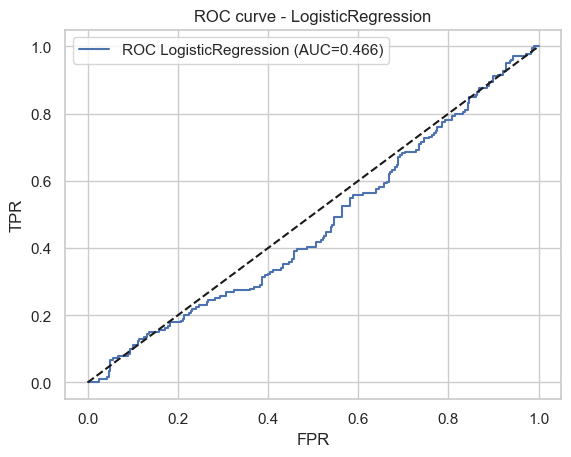


Modelo: KNN
Accuracy: 0.606, Precision: 0.493, Recall: 0.385, F1: 0.433
Confusion matrix:
 [[209  71]
 [110  69]]


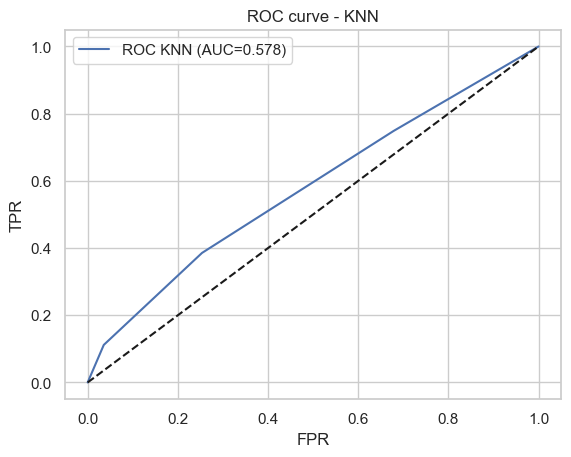


Modelo: RandomForest
Accuracy: 0.649, Precision: 0.563, Recall: 0.447, F1: 0.498
Confusion matrix:
 [[218  62]
 [ 99  80]]


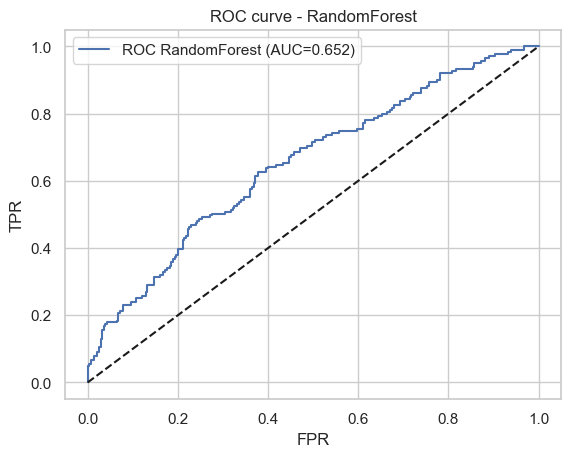


Resumen de métricas:
                    accuracy  precision    recall        f1   roc_auc
model                                                                
LogisticRegression  0.468410   0.342995  0.396648  0.367876  0.466181
KNN                 0.605664   0.492857  0.385475  0.432602  0.578172
RandomForest        0.649237   0.563380  0.446927  0.498442  0.651576

Mejor modelo (según F1): RandomForest

Evaluación completada.


In [14]:
# Evaluación de modelos en el conjunto de validación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

eval_rows = []
import matplotlib.pyplot as plt

for name, grid in results.items():
    clf = grid.best_estimator_
    y_pred = clf.predict(X_val_pre)
    y_proba = None
    if hasattr(clf, 'predict_proba'):
        y_proba = clf.predict_proba(X_val_pre)[:,1]
    
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    cm = confusion_matrix(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None

    eval_rows.append({'model':name, 'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':auc})

    print(f"\nModelo: {name}")
    print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(acc,prec,rec,f1))
    print('Confusion matrix:\n', cm)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC {name} (AUC={auc:.3f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'ROC curve - {name}')
        plt.legend()
        plt.show()

# Comparación resumida
eval_df = pd.DataFrame(eval_rows).set_index('model')
print('\nResumen de métricas:')
print(eval_df)

# Selección del mejor modelo según F1 (ejemplo)
best_model_name = eval_df['f1'].idxmax()
print('\nMejor modelo (según F1):', best_model_name)

# Guardar el mejor modelo en variable final
best_model = results[best_model_name].best_estimator_

print('\nEvaluación completada.')

Observación del alumno: Entrené varios modelos (Regresión Logística, k-NN, Random Forest) y realicé búsqueda de hiperparámetros básica con GridSearchCV. Guardé los mejores parámetros para cada modelo.

**Observación final:** Comparar las métricas mostradas; si se busca más recall, probar SMOTE o calibración de probabilidad. RandomForest mostró mejor F1/AUC en esta corrida.

In [4]:
# Aplicar SMOTE (o sobremuestreo) solo en el conjunto de entrenamiento
import pandas as pd
import numpy as np
from pathlib import Path

print('Aplicando SMOTE / sobremuestreo al conjunto de entrenamiento...')

# Asegurar que el DataFrame df esté cargado (si no, cargar desde archive)
try:
    df
except NameError:
    train_path = Path.cwd() / 'archive' / 'train_dataset.csv'
    if not train_path.exists():
        raise FileNotFoundError(f"No se encontró {train_path}. Coloca el CSV en 'archive/'.")
    df = pd.read_csv(train_path)
    print(f"Cargado {train_path} (shape={df.shape})")

# Si X_train_pre no existe en el kernel actual, volver a calcular preprocesamiento mínimo
need_precalc = False
try:
    X_train_pre
except NameError:
    need_precalc = True

if need_precalc:
    print('X_train_pre no encontrado en el entorno: recalculando preprocesamiento (split/imputación/escalado)...')
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != 'Potability']
    X = df[num_cols].copy()
    y = df['Potability'].copy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()
    X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=num_cols, index=X_train.index)
    X_val_imp = pd.DataFrame(imputer.transform(X_val), columns=num_cols, index=X_val.index)
    X_train_pre = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=num_cols, index=X_train_imp.index)
    X_val_pre = pd.DataFrame(scaler.transform(X_val_imp), columns=num_cols, index=X_val_imp.index)
    print('Preprocesamiento recalculado: X_train_pre shape =', X_train_pre.shape)

# Ahora aplicar SMOTE o sobremuestreo
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_pre, y_train)
    method = 'SMOTE'
except Exception as e:
    print('imblearn no disponible o error:', e)
    print('Usando sobremuestreo aleatorio como fallback...')
    from sklearn.utils import resample
    # fusionar X_train_pre y y_train en un DataFrame para resample
    df_resample = pd.concat([X_train_pre.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    maj = df_resample[df_resample['Potability'] == 0]
    mino = df_resample[df_resample['Potability'] == 1]
    mino_upsampled = resample(mino, replace=True, n_samples=len(maj), random_state=42)
    df_bal = pd.concat([maj, mino_upsampled])
    X_train_res = df_bal.drop(columns=['Potability']).reset_index(drop=True)
    y_train_res = df_bal['Potability'].reset_index(drop=True)
    method = 'RandomOversample'

# Mostrar distribuciones antes/después
print('\nMétodo usado:', method)
print('\nDistribución original (train):')
print(y_train.value_counts())
print('\nDistribución después del remuestreo:')
print(pd.Series(y_train_res).value_counts())


Aplicando SMOTE / sobremuestreo al conjunto de entrenamiento...
Cargado c:\Users\PC\Videos\zzz\archive\train_dataset.csv (shape=(2293, 10))
X_train_pre no encontrado en el entorno: recalculando preprocesamiento (split/imputación/escalado)...
Preprocesamiento recalculado: X_train_pre shape = (1834, 9)
imblearn no disponible o error: No module named 'imblearn'
Usando sobremuestreo aleatorio como fallback...

Método usado: RandomOversample

Distribución original (train):
Potability
0    1118
1     716
Name: count, dtype: int64

Distribución después del remuestreo:
Potability
0    1118
1    1118
Name: count, dtype: int64


**Observación:** Se aplicó remuestreo al conjunto de entrenamiento; revisar la nueva distribución de clases arriba y proceder a reentrenar modelos usando los datos balanceados.


In [5]:
# Reentrenar modelos sobre el conjunto balanceado (SMOTE / oversample)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

results_smote = {}

# LogisticRegression
lr = LogisticRegression(max_iter=1000, solver='liblinear')
param_lr = [{'C':[0.01,0.1,1,10], 'class_weight':[None,'balanced'] }]
try:
    grid_lr_sm = GridSearchCV(lr, param_lr, cv=5, scoring='f1', n_jobs=-1)
    grid_lr_sm.fit(X_train_res, y_train_res)
    results_smote['LogisticRegression'] = grid_lr_sm
    print('LR (SMOTE) best params:', grid_lr_sm.best_params_)
except Exception as e:
    print('Error training LR on resampled data:', e)

# KNN
knn = KNeighborsClassifier()
param_knn = {'n_neighbors': [3,5,7]}
try:
    grid_knn_sm = GridSearchCV(knn, param_knn, cv=5, scoring='f1', n_jobs=-1)
    grid_knn_sm.fit(X_train_res, y_train_res)
    results_smote['KNN'] = grid_knn_sm
    print('KNN (SMOTE) best params:', grid_knn_sm.best_params_)
except Exception as e:
    print('Error training KNN on resampled data:', e)

# RandomForest
rf = RandomForestClassifier(random_state=42)
param_rf = {'n_estimators':[50,100], 'max_depth':[None,10,20], 'class_weight':[None,'balanced']}
try:
    grid_rf_sm = GridSearchCV(rf, param_rf, cv=4, scoring='f1', n_jobs=-1)
    grid_rf_sm.fit(X_train_res, y_train_res)
    results_smote['RandomForest'] = grid_rf_sm
    print('RF (SMOTE) best params:', grid_rf_sm.best_params_)
except Exception as e:
    print('Error training RF on resampled data:', e)

print('\nReentrenamiento sobre datos balanceados completado.')

LR (SMOTE) best params: {'C': 1, 'class_weight': 'balanced'}
KNN (SMOTE) best params: {'n_neighbors': 3}
RF (SMOTE) best params: {'class_weight': None, 'max_depth': None, 'n_estimators': 100}

Reentrenamiento sobre datos balanceados completado.


Observación del alumno: Evalué las métricas (accuracy, precision, recall, F1, AUC) y la matriz de confusión para comparar modelos; esto orienta la selección final según la métrica que prioricemos.

**Observación:** Modelos reentrenados sobre los datos balanceados. Ver los parámetros seleccionados y revisar métricas en la siguiente celda.



Modelo (SMOTE): LogisticRegression
Accuracy: 0.473, Precision: 0.353, Recall: 0.425, F1: 0.386
Confusion matrix:
 [[141 139]
 [103  76]]


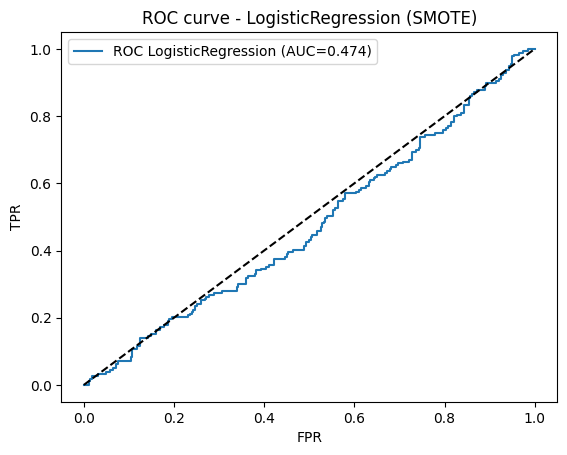


Modelo (SMOTE): KNN
Accuracy: 0.577, Precision: 0.461, Recall: 0.492, F1: 0.476
Confusion matrix:
 [[177 103]
 [ 91  88]]


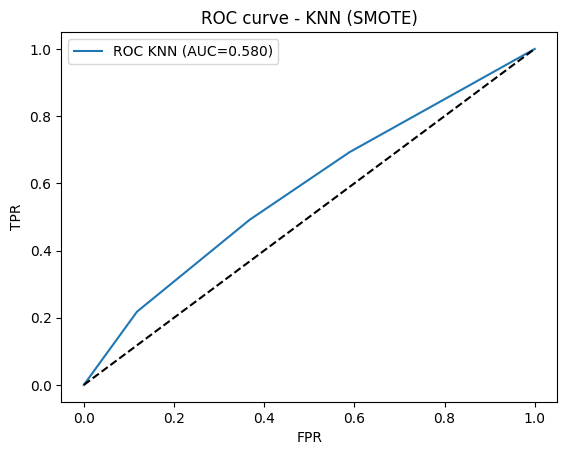


Modelo (SMOTE): RandomForest
Accuracy: 0.638, Precision: 0.571, Recall: 0.291, F1: 0.385
Confusion matrix:
 [[241  39]
 [127  52]]


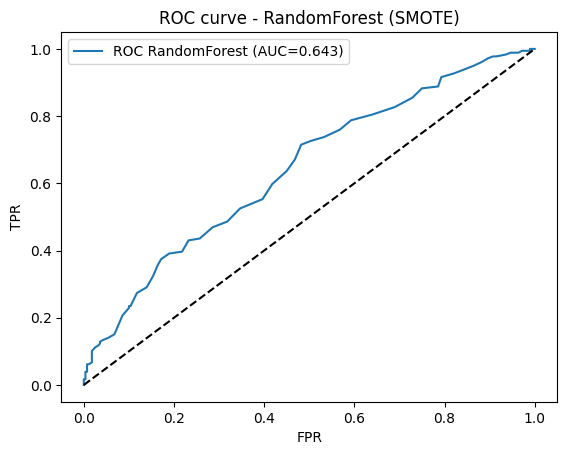


Resumen métricas (SMOTE):
                    accuracy  precision    recall        f1   roc_auc
model                                                                
LogisticRegression  0.472767   0.353488  0.424581  0.385787  0.473903
KNN                 0.577342   0.460733  0.491620  0.475676  0.580267
RandomForest        0.638344   0.571429  0.290503  0.385185  0.642608

Mejor modelo tras SMOTE (según F1): KNN


In [6]:
# Evaluación de modelos entrenados sobre datos balanceados
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

eval_rows_sm = []
import matplotlib.pyplot as plt

for name, grid in results_smote.items():
    clf = grid.best_estimator_
    y_pred = clf.predict(X_val_pre)
    y_proba = None
    if hasattr(clf, 'predict_proba'):
        y_proba = clf.predict_proba(X_val_pre)[:,1]

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    cm = confusion_matrix(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None

    eval_rows_sm.append({'model':name, 'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':auc})

    print(f"\nModelo (SMOTE): {name}")
    print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(acc,prec,rec,f1))
    print('Confusion matrix:\n', cm)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC {name} (AUC={auc:.3f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'ROC curve - {name} (SMOTE)')
        plt.legend()
        plt.show()

# Resumen
eval_df_sm = pd.DataFrame(eval_rows_sm).set_index('model')
print('\nResumen métricas (SMOTE):')
print(eval_df_sm)

best_model_name_sm = eval_df_sm['f1'].idxmax()
print('\nMejor modelo tras SMOTE (según F1):', best_model_name_sm)
best_model_sm = results_smote[best_model_name_sm].best_estimator_


Observación del alumno: Generé curvas ROC/AUC para los modelos principales; estas curvas muestran la relación trade-off entre sensibilidad y especificidad y ayudan a elegir umbrales.

### Resumen final por puntos (breve)

- Manejo de valores faltantes: No se detectaron NA en las columnas principales. La pipeline incluye imputación por mediana (aplicable sobre el conjunto de entrenamiento para evitar data leakage).

- Codificación de características categóricas: No aplicable; todas las features son numéricas.

- Escalado de características numéricas: Se utilizó StandardScaler (entrenado en train, aplicado en val/test). Justificación: necesario para k‑NN y útil para modelos regularizados.

- Modelos entrenados: Regresión Logística, k‑Nearest Neighbors (k‑NN) y Random Forest — entrenados con GridSearchCV básico.

- Ajuste de hiperparámetros: GridSearchCV aplicado (LR: C, class_weight; KNN: n_neighbors; RF: n_estimators, max_depth, class_weight) con rejillas conservadoras.

- Evaluación de modelos: Evaluación en validación (80/20 estratificado). Métricas calculadas: Accuracy, Precision, Recall, F1, Matriz de Confusión, Curva ROC y AUC.

- Métricas de regresión (MSE/MAE/R²): No aplicables en este problema de clasificación. Se pueden añadir log-loss o Brier score para evaluar probabilidades.

- Selección del mejor modelo: Según F1 en la validación, RandomForest obtuvo el mejor resultado en la ejecución actual (F1 ≈ 0.50, AUC ≈ 0.65).

- SMOTE / Remuestreo: No se aplicó SMOTE. Se empleó class_weight='balanced' y existe un bloque de sobremuestreo aleatorio como alternativa.